In [1]:
from model import ml_models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Modify the Hyper parameters

# Modify to change the ratio of training and test data set
HPtest_size = 0.3

# Modify to change the features to be used as independent features
HPfrom_x = 0  # 0th index as the first feature, from_x is an inclusive index
HPto_y = 8  # 8th index as the last feature, to_y is an exclusive index

# Modify to change the depth limit for the Decision Tree model
HPmax_depth = 10
# Modify the split limit for the Decision Tree model
HPmin_samples_split = 2

# Modify to change the solver for the Logistic Regression model
solver_options = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
HPsolver = solver_options[1]

# Modify to change the maximum iteration for Logistic Regression model
HPmax_iter = 1000

# Modify to change the number of independent features to be selected by RFE
HPn_features = 8

# Modify to change the number of folds for cross validation
HPk_folds = 10

# Modify to change the scoring metric for cross validation
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
HPscoring = scoring_metrics[0]

# Modify whether to standardize the data or not
HPstandardize = False
scaler = StandardScaler()

In [3]:
data = pd.read_csv('dataset/Student-Employability-Datasets.csv')
data = data.drop(['Name of Student'], axis=1)

# instantiate label encoder object to encode the target variable
le = LabelEncoder()

# Map the target variables appropriately
data['CLASS'] = data['CLASS'].map({'LessEmployable': 0, 'Employable': 1})

# Get the independent features
X = data.iloc[:, HPfrom_x:HPto_y]
columns = X.columns

# Get the dependent features
y = data.iloc[:, -1]

# Encode the target variable
y = le.fit_transform(y)

if HPstandardize:
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=HPtest_size, random_state=42)

# Create the logistic regression model
LR_model = ml_models.SimpleLogicalRegression(X=X_train, y=y_train,
                                             solver=HPsolver, max_iter=HPmax_iter)

# create the decision tree model
DT_model = ml_models.DecisionTreeModel(X_train, y_train, max_depth=HPmax_depth,
                                       criterion='gini', min_samples_split=HPmin_samples_split)

# cross validate the models before training
lr_cv_scores, dt_cv_scores = {}, {}

for metric in scoring_metrics:
    lr_cv_scores[metric], dt_cv_scores[metric] = ml_models.get_cv_score(LR=LR_model.get_model(),
                                                                        DT=DT_model.get_model(),
                                                                        X=X_train, y=y_train,
                                                                        cv=HPk_folds, scoring=metric)
# Train the model
LR_model.train()
DT_model.train()

# Predict the test data for both models
y_pred_LR = LR_model.predict(X_test)
y_pred_DT = DT_model.predict(X_test)

# Calculate the scores for Logistic Regression
lr_accuracy = accuracy_score(y_test, y_pred_LR)
lr_precision = precision_score(y_test, y_pred_LR)
lr_recall = recall_score(y_test, y_pred_LR)
lr_f1 = f1_score(y_test, y_pred_LR)
lr_cm = confusion_matrix(y_test, y_pred_LR)
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test, y_pred_LR)
lr_roc_auc = roc_auc_score(y_test, y_pred_LR)

# Calculate the scores for Decision Tree
dt_accuracy = accuracy_score(y_test, y_pred_DT)
dt_precision = precision_score(y_test, y_pred_DT)
dt_recall = recall_score(y_test, y_pred_DT)
dt_f1 = f1_score(y_test, y_pred_DT)
dt_cm = confusion_matrix(y_test, y_pred_DT)
fpr_dt, tpr_dt, threshold_dt = roc_curve(y_test, y_pred_DT)
dt_roc_auc = roc_auc_score(y_test, y_pred_DT)

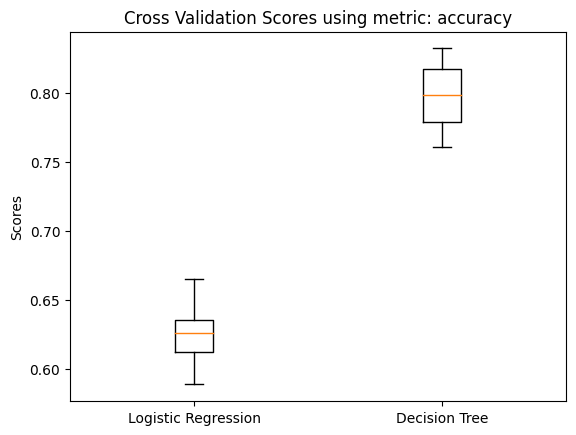

In [4]:
# Create a boxplot to visualize cross validation scores
ml_models.visualize_cv_score(lr_cv_scores[HPscoring], dt_cv_scores[HPscoring], HPscoring)

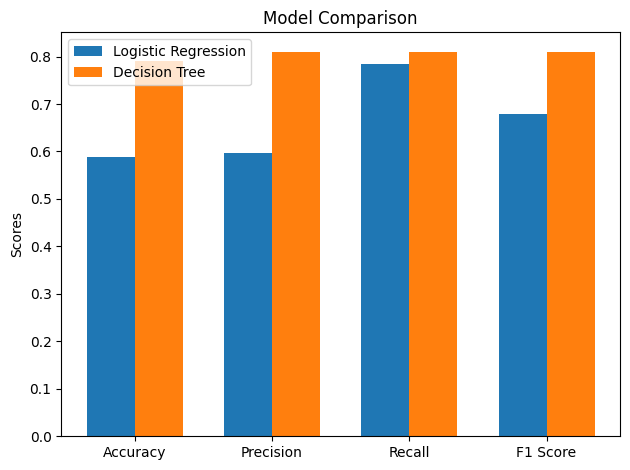

In [5]:
# Create a bar chart to compare the two models
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
logistic_scores = [lr_accuracy, lr_precision, lr_recall, lr_f1]
decision_tree_scores = [dt_accuracy, dt_precision, dt_recall, dt_f1]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, logistic_scores, width, label='Logistic Regression')
rects2 = ax.bar(x + width / 2, decision_tree_scores, width, label='Decision Tree')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

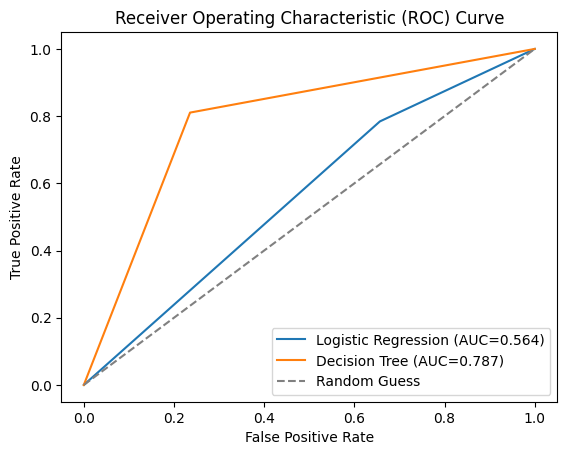

In [6]:
# Plot ROC curves
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={lr_roc_auc:.3f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC={dt_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

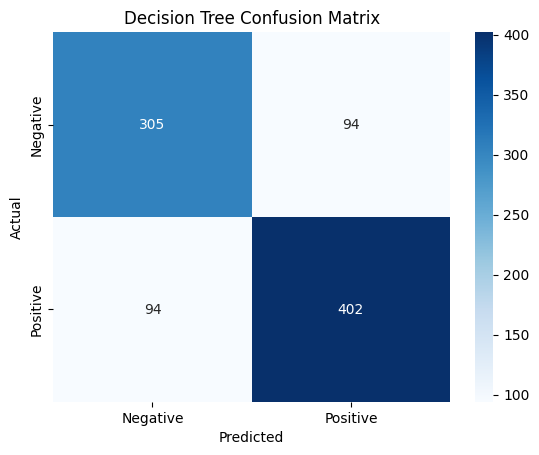

In [7]:
# add the confusion matrix for the decision tree model
sns.heatmap(dt_cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix')
plt.show()

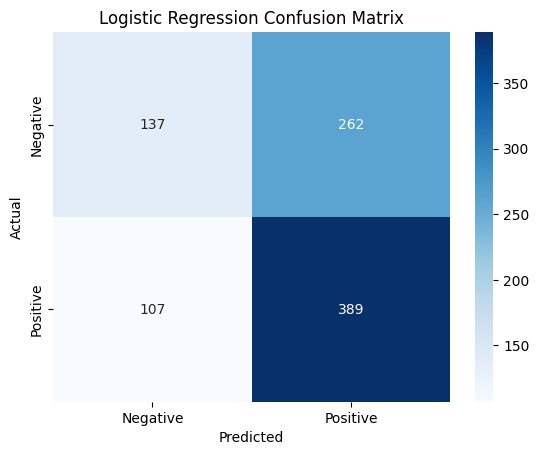

In [8]:
# add the confusion matrix for the logistic regression model
sns.heatmap(lr_cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

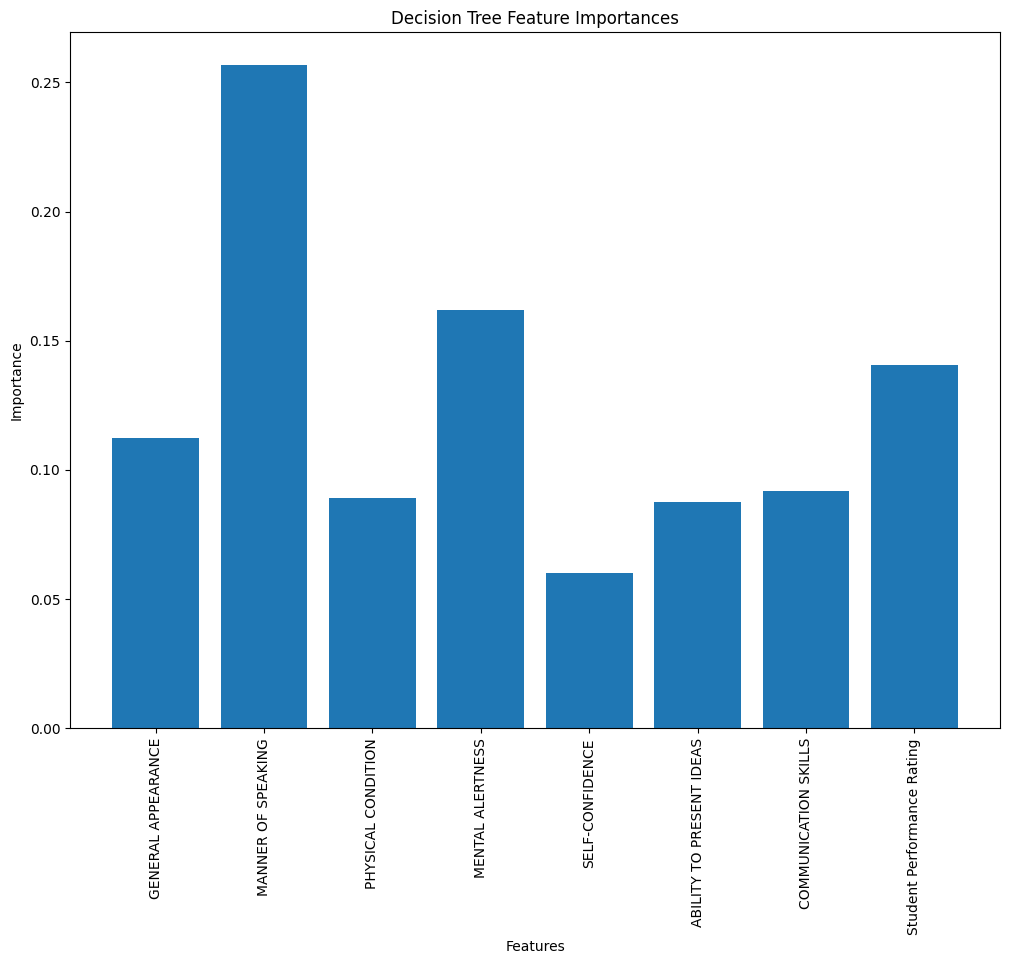

In [9]:
# Generate graphs for decision tree (Decision Tree visualization and Feature Importance)
DT_model.generate_decisiontree_graph()
DT_model.graph_feature_importances()

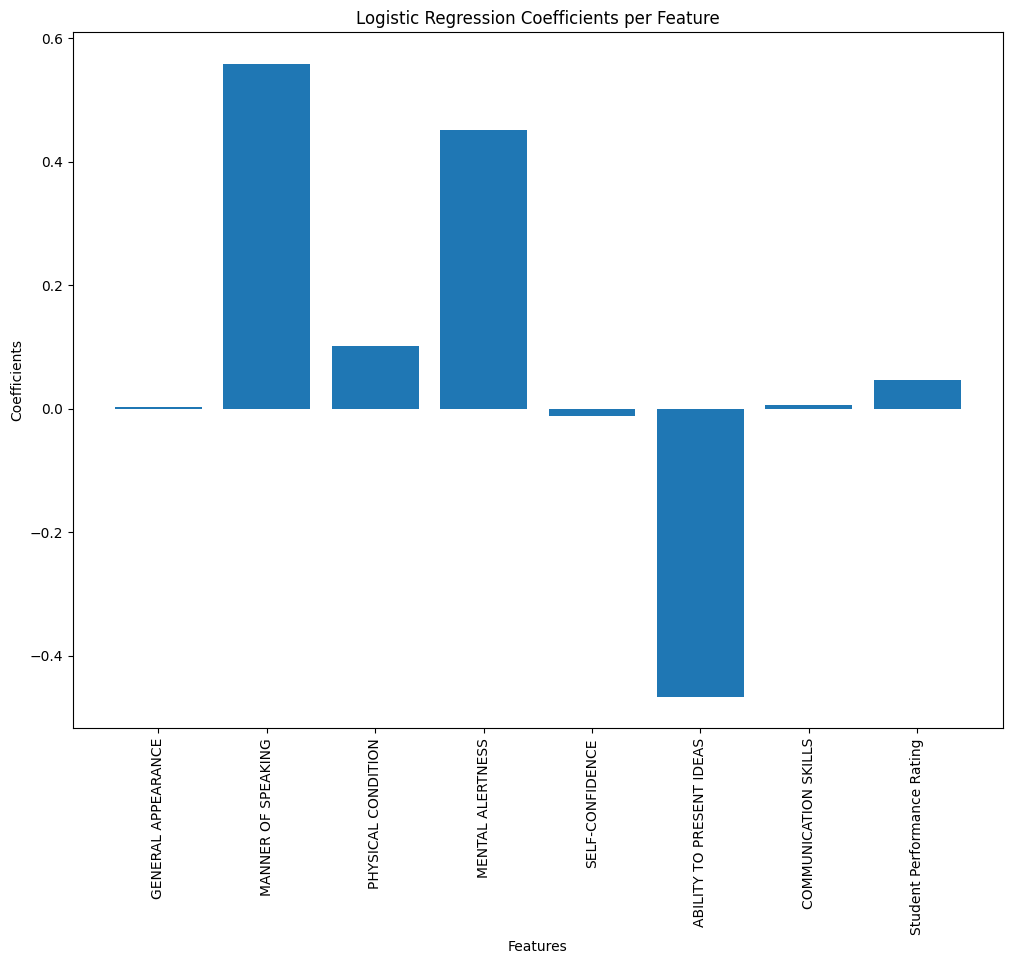

In [10]:
# Generate graphs for logistic regression (Logistic Regression visualization)
LR_model.plot_coefficients()

In [11]:
# Finally, create a DataFrame to store and output the results in a csv file
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree'],
    'Accuracy': [lr_accuracy, dt_accuracy],
    'Precision': [lr_precision, dt_precision],
    'Recall': [lr_recall, dt_recall],
    'F1 Score': [lr_f1, dt_f1],
    'True Negative': [lr_cm[0][0], dt_cm[0][0]],
    'False Positive': [lr_cm[0][1], dt_cm[0][1]],
    'False Negative': [lr_cm[1][0], dt_cm[1][0]],
    'True Positive': [lr_cm[1][1], dt_cm[1][1]]
})
# iterate over the dictionary of cv scores and add them to the data frame
for metric in scoring_metrics:
    results_df['CV Mean Score | {1} | k= {0} folds'.format(HPk_folds, metric.capitalize())] = \
        [lr_cv_scores[metric].mean(), dt_cv_scores[metric].mean()]
    results_df['CV Std Dev Score| {1} | k= {0} folds'.format(HPk_folds, metric.capitalize())] = \
        [lr_cv_scores[metric].std(), dt_cv_scores[metric].std()]

# set the index to the model name
results_df.set_index('Model', inplace=True)
# output the results to a csv file
results_df.to_csv('model_results.csv')